In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import re
import cv2
import skimage
from pathlib import Path
import shutil
import random
from PIL import Image
from torchvision import transforms, datasets, models
from sklearn.model_selection import train_test_split
import seaborn as sns

from timeit import default_timer as timer
from torch.utils.data import DataLoader
from torch import optim, cuda

In [2]:
cuda.is_available()

True

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
# img_zip_path = 'dataset/Category and Attribute Prediction Benchmark/Img/img.zip'
# output_folder = 'dataset/'

In [5]:
# sorted(os.listdir('dataset'))

In [6]:
# import zipfile
# with zipfile.ZipFile(img_zip_path, 'r') as zip_ref:
#     zip_ref.extractall(output_folder)

# Data visualization and preprocessing

In [7]:
# c = 0
# for r, d, f in os.walk('/content/drive/My Drive/cv_project/img'):
#   c += len(f)
# print(c)

In [8]:
dataset_path = Path('dataset/')
annotations_path = Path('dataset/Anno/')

categories_path = annotations_path / 'list_category_img.txt'
clothes_path = annotations_path / 'list_category_cloth.txt'
bbox_path = annotations_path / 'list_bbox.txt'

In [9]:
def read_categories(fname):
    img_cat = {'path': [], 'category': []}
    cat_imgs = {}
    with open(fname, "r") as file:
        i = 0
        for line in file:
            if i < 2:
                i += 1
            else:
                path, cat = line.split()
                img_cat['path'].append(path)
                img_cat['category'].append(cat)
                cat_imgs.setdefault(cat, [])
                cat_imgs[cat].append(path)
    img_cat = pd.DataFrame(img_cat)
    img_cat['category'] = img_cat['category'].astype('int64')
    return img_cat, cat_imgs

In [10]:
def read_bboxes(fname):
    img_bbox = {'path': [], 'x1': [], 'y1': [], 'x2': [], 'y2': []}
    with open(fname, "r") as file:
        i = 0
        for line in file:
            if i < 2:
                i += 1
            else:
                path, x_1,  y_1,  x_2,  y_2 = line.split()
                img_bbox['path'].append(path)
                img_bbox['x1'].append(x_1)
                img_bbox['y1'].append(y_1)
                img_bbox['x2'].append(x_2)
                img_bbox['y2'].append(y_2)
    
    img_bbox = pd.DataFrame(img_bbox)
    return img_bbox

In [11]:
def read_clothes(fname):
    cloth_cat = {'catname': [], 'category': []}
    with open(fname, "r") as file:
        i = 0
        for line in file:
            if i > 1:
                cloth, _ = line.split()
                cloth_cat['catname'].append(cloth)
                cloth_cat['category'].append(i - 1)
            i += 1
    cloth_cat = pd.DataFrame(cloth_cat)
    cloth_cat['category'] = cloth_cat['category'].astype('int64')
    return cloth_cat

In [12]:
def get_subdir_name(path):
    plist = Path(path).parts
    return plist[-2]

def add_subdir_column(df):
    df['subdir'] = df['path'].apply(get_subdir_name)

In [13]:
def add_catname_column(df, catnames):
    return df.merge(catnames, on='category')

In [14]:
img_cat, cat_imgs = read_categories(categories_path)
img_bbox = read_bboxes(bbox_path)
clothes = read_clothes(clothes_path)

In [15]:
img_cat.head(10)

,path,category
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,3
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,3
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,3
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,3
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,3
5,img/Sheer_Pleated-Front_Blouse/img_00000006.jpg,3
6,img/Sheer_Pleated-Front_Blouse/img_00000007.jpg,3
7,img/Sheer_Pleated-Front_Blouse/img_00000008.jpg,3
8,img/Sheer_Pleated-Front_Blouse/img_00000009.jpg,3
9,img/Sheer_Pleated-Front_Blouse/img_00000010.jpg,3


In [16]:
img_bbox.head(10)

,path,x1,y1,x2,y2
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,072,079,232,273
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,067,059,155,161
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,065,065,156,200
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,051,062,167,182
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,046,088,166,262
5,img/Sheer_Pleated-Front_Blouse/img_00000006.jpg,047,067,211,241
6,img/Sheer_Pleated-Front_Blouse/img_00000007.jpg,018,073,200,241
7,img/Sheer_Pleated-Front_Blouse/img_00000008.jpg,075,074,197,246
8,img/Sheer_Pleated-Front_Blouse/img_00000009.jpg,024,056,149,235
9,img/Sheer_Pleated-Front_Blouse/img_00000010.jpg,019,096,192,203


In [17]:
clothes.head(10)

,catname,category
0,Anorak,1
1,Blazer,2
2,Blouse,3
3,Bomber,4
4,Button-Down,5
5,Cardigan,6
6,Flannel,7
7,Halter,8
8,Henley,9
9,Hoodie,10


In [18]:
categories = []
category_sizes = []
for key in cat_imgs:
    categories.append(key)
    category_sizes.append(len(cat_imgs[key]))

In [19]:
# number of classes
len(categories)

46

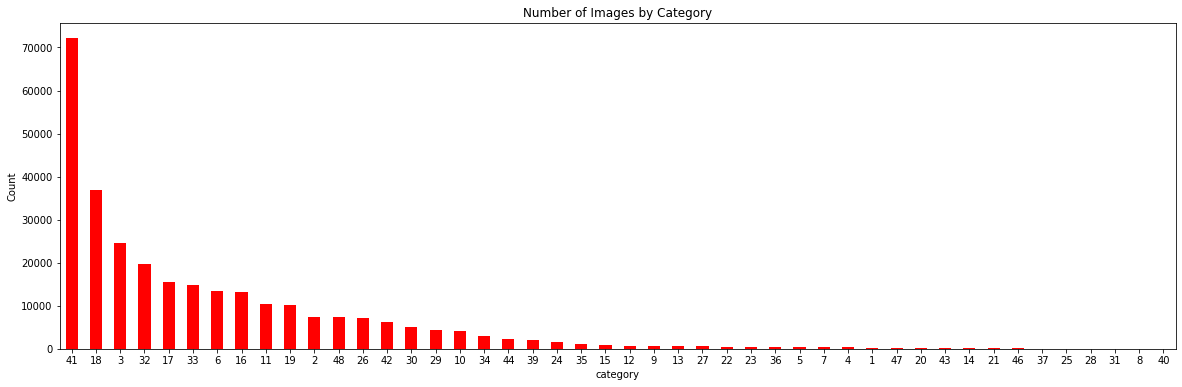

In [20]:
cat_df = pd.DataFrame({'category': categories, 'category_size': category_sizes})
cat_df.sort_values('category_size', ascending=False, inplace=True)
cat_df.set_index('category')['category_size'].plot.bar(color='r', figsize=(20, 6))
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.title('Number of Images by Category')
plt.savefig('classes_histogram_all.png', bbox_inches = 'tight')

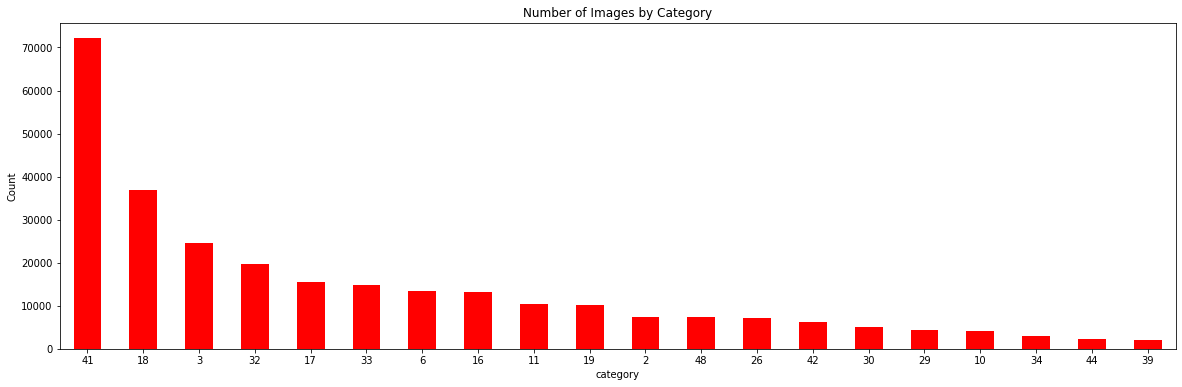

In [21]:
# Only top 20 categories
cat_df.set_index('category').iloc[:20]['category_size'].plot.bar(
    color='r', figsize=(20, 6))
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.title('Number of Images by Category')
plt.savefig('classes_histogram_top.png', bbox_inches = 'tight')

In [22]:
popular_cats = [c for c, n in zip(categories, category_sizes) if n > 2000]
obscure_cats = [c for c, n in zip(categories, category_sizes) if n < 500]
clothes_dict = {row.category: row.catname for i, row in clothes.iterrows()}

popular_clothes = [clothes_dict[int(popular_cat)] for popular_cat in popular_cats]
obscure_clothes = [clothes_dict[int(obscure_cat)] for obscure_cat in obscure_cats]

print(len(popular_cats), 'well represented clothes:', len(popular_clothes))
print(popular_clothes)
print()
print('Poorly represented clothes:')
print(obscure_clothes)

20 well represented clothes: 20
['Blouse', 'Blazer', 'Tee', 'Tank', 'Top', 'Sweater', 'Hoodie', 'Cardigan', 'Jacket', 'Skirt', 'Shorts', 'Jeans', 'Joggers', 'Sweatpants', 'Leggings', 'Dress', 'Romper', 'Coat', 'Kimono', 'Jumpsuit']

Poorly represented clothes:
['Button-Down', 'Bomber', 'Anorak', 'Flannel', 'Turtleneck', 'Peacoat', 'Halter', 'Culottes', 'Trunks', 'Sarong', 'Gauchos', 'Jodhpurs', 'Capris', 'Robe', 'Caftan', 'Kaftan', 'Coverup', 'Onesie']


In [26]:
def read_images(files, prefix=''):
    images = []
    for file in files:
        images.append(Image.open(str(Path(prefix) / file)))
    return images
###
def print_images(images, rows, cols):
    fig = plt.figure(figsize=(cols * 4, rows * 4))
    for i in range(1, rows * cols + 1):
        fig.add_subplot(rows, cols, i, frameon=False, xticks=[], yticks=[])
        plt.imshow(images[i - 1])

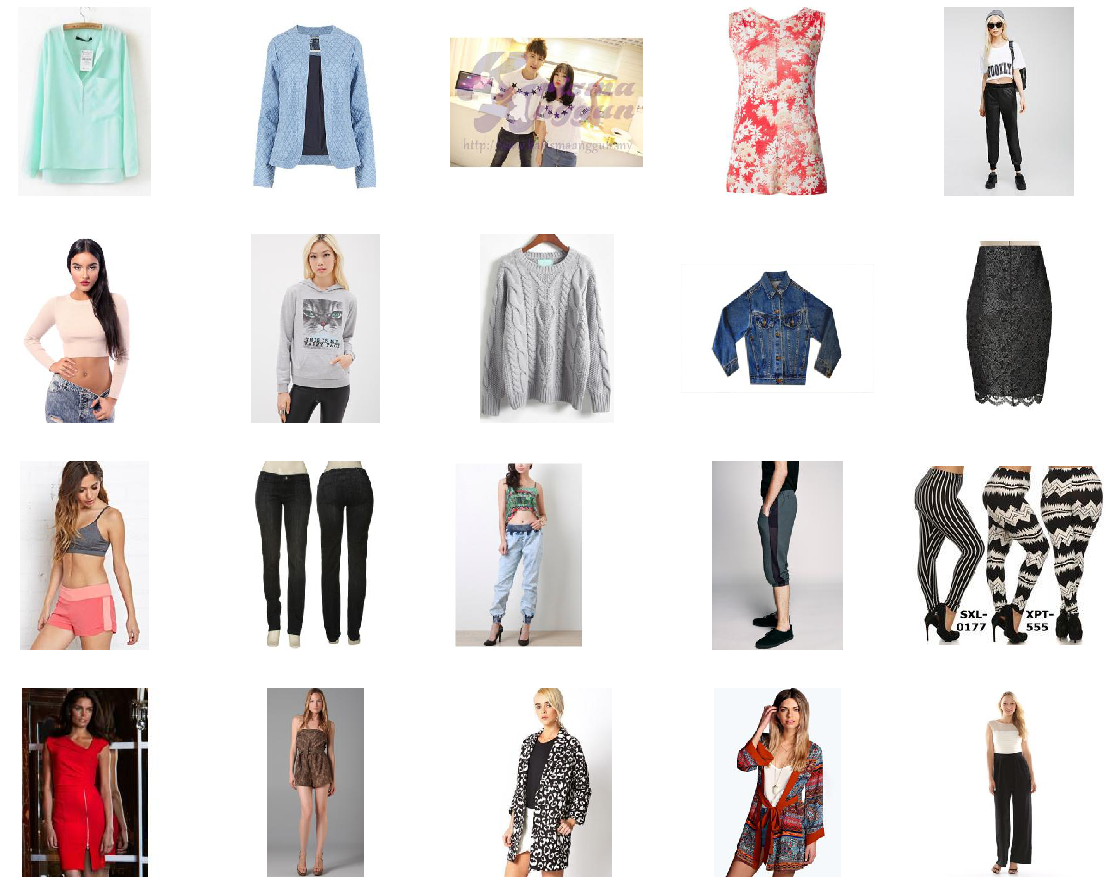

In [27]:
# display random image from each of popular categories
random_img_names = [cat_imgs[cat][random.randint(1, len(cat_imgs[cat]) - 1)] for cat in popular_cats]
random_imgs = read_images(random_img_names, prefix=dataset_path)
print_images(random_imgs, 4, 5)
plt.savefig('random_images.png', bbox_inches = 'tight')

In [25]:
'''
Rearrange dataset for transfer learning as follows:

<dataset_name>
|---train
|    |---cat1
|    |---cat2
|    
|---test
|    |---cat1
|    |---cat2
|    
|---valid
|    |---cat1
|    |---cat2
|
'''

# Create folders or ask what to do if they exist
def create_dataset_structure(root, dataset_name, categories):
    root = Path(root)
    dataset_path = root / dataset_name
    if os.path.exists(str(dataset_path)):
        if input(f'Dataset {dataset_path} already exist. Delete? [y/n]').lower() == 'y':
            shutil.rmtree(str(dataset_path), ignore_errors=True)
        else:
            return
    os.mkdir(str(dataset_path))
    for subdir_name in ['train', 'test', 'valid']:
        subdir_path = dataset_path / subdir_name
        os.mkdir(str(subdir_path))
        for cat in categories:
            os.mkdir(str(subdir_path / cat))

def fill_dataset(dataset_path, train_df, test_df, valid_df,
                 prefix='', category_colun='category', catname_column='catname', path_column='path'):
    dataset_path = Path(dataset_path)
    for subdir, df in zip(['train', 'test', 'valid'], [train_df, test_df, valid_df]):
        subdir_path = dataset_path / subdir
        print(f'Fill {subdir}')
        total = len(df.index)
        count = 0
        step = max(5, (total * 5) // 100)
        for i, row in df.iterrows():
            category_name = row[catname_column]
            img_path = Path(row[path_column])
            src = str(Path(prefix) / img_path)
            dst = str(subdir_path / category_name / f'{img_path.parts[-2]}_{img_path.parts[-1]}')
            shutil.copyfile(src, dst)
            count += 1
            if count % step == 0:
                print(f'\tprogress: {100 * count / total:.2f}%')

## Add some necessary columns

In [26]:
# add category to bbox
img_bbox = img_bbox.merge(img_cat, on='path')

In [27]:
# add subdir names (detailed clothes)
add_subdir_column(img_bbox)
add_subdir_column(img_cat)

In [28]:
# add category names
img_bbox = add_catname_column(img_bbox, clothes)
img_cat = add_catname_column(img_cat, clothes)

In [29]:
img_bbox.head(10)

,path,x1,y1,x2,y2,category,subdir,catname
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,072,079,232,273,3,Sheer_Pleated-Front_Blouse,Blouse
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,067,059,155,161,3,Sheer_Pleated-Front_Blouse,Blouse
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,065,065,156,200,3,Sheer_Pleated-Front_Blouse,Blouse
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,051,062,167,182,3,Sheer_Pleated-Front_Blouse,Blouse
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,046,088,166,262,3,Sheer_Pleated-Front_Blouse,Blouse
5,img/Sheer_Pleated-Front_Blouse/img_00000006.jpg,047,067,211,241,3,Sheer_Pleated-Front_Blouse,Blouse
6,img/Sheer_Pleated-Front_Blouse/img_00000007.jpg,018,073,200,241,3,Sheer_Pleated-Front_Blouse,Blouse
7,img/Sheer_Pleated-Front_Blouse/img_00000008.jpg,075,074,197,246,3,Sheer_Pleated-Front_Blouse,Blouse
8,img/Sheer_Pleated-Front_Blouse/img_00000009.jpg,024,056,149,235,3,Sheer_Pleated-Front_Blouse,Blouse
9,img/Sheer_Pleated-Front_Blouse/img_00000010.jpg,019,096,192,203,3,Sheer_Pleated-Front_Blouse,Blouse


In [30]:
img_cat.head(10)

,path,category,subdir,catname
0,img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,3,Sheer_Pleated-Front_Blouse,Blouse
1,img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,3,Sheer_Pleated-Front_Blouse,Blouse
2,img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,3,Sheer_Pleated-Front_Blouse,Blouse
3,img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,3,Sheer_Pleated-Front_Blouse,Blouse
4,img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,3,Sheer_Pleated-Front_Blouse,Blouse
5,img/Sheer_Pleated-Front_Blouse/img_00000006.jpg,3,Sheer_Pleated-Front_Blouse,Blouse
6,img/Sheer_Pleated-Front_Blouse/img_00000007.jpg,3,Sheer_Pleated-Front_Blouse,Blouse
7,img/Sheer_Pleated-Front_Blouse/img_00000008.jpg,3,Sheer_Pleated-Front_Blouse,Blouse
8,img/Sheer_Pleated-Front_Blouse/img_00000009.jpg,3,Sheer_Pleated-Front_Blouse,Blouse
9,img/Sheer_Pleated-Front_Blouse/img_00000010.jpg,3,Sheer_Pleated-Front_Blouse,Blouse


## Delete poorly represented classes 

In [31]:
print(len(img_cat.index))
print(len(img_bbox.index))

289222
289222


In [32]:
img_cat = img_cat[img_cat.category.map(lambda c: str(c) in popular_cats)]
img_bbox = img_bbox[img_bbox.category.map(lambda c: str(c) in popular_cats)]

In [33]:
print(len(img_cat.index))
print(len(img_bbox.index))

279520
279520


In [34]:
sorted(img_bbox.category.unique())

[2, 3, 6, 10, 11, 16, 17, 18, 19, 26, 29, 30, 32, 33, 34, 39, 41, 42, 44, 48]

In [35]:
sorted(np.array(list(map(int, popular_cats))))

[2, 3, 6, 10, 11, 16, 17, 18, 19, 26, 29, 30, 32, 33, 34, 39, 41, 42, 44, 48]

## Train test split

In [36]:
img_cat_tt, img_cat_valid = train_test_split(img_cat, test_size=0.1, stratify=img_cat['catname'], random_state=41, shuffle=True)

In [37]:
img_cat_train, img_cat_test = train_test_split(img_cat_tt, test_size=0.15, stratify=img_cat_tt['catname'], random_state=42, shuffle=True)

In [ ]:
# create_dataset_structure('dataset', 'ds1', list(img_cat.catname.unique()))

In [38]:
n_train = len(img_cat_train.index)
n_test = len(img_cat_test.index)
n_valid = len(img_cat_valid.index)
n_total = len(img_cat.index)
print(n_train, n_test, n_valid, n_total, n_total - n_test - n_train - n_valid)

213832 37736 27952 279520 0


In [ ]:
# fill_dataset('dataset/ds1', img_cat_train, img_cat_test, img_cat_valid, prefix=dataset_path)

# Transfer learning

In [39]:
# Image transformations
INCEPTION_V3_IMG_SIZE = 299

image_transform = \
    transforms.Compose([
        transforms.Resize(size=INCEPTION_V3_IMG_SIZE),
        transforms.CenterCrop(size=INCEPTION_V3_IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [40]:
batch_size = 256

# Whether to train on a gpu
train_on_gpu = cuda.is_available()
print(f'Train on gpu: {train_on_gpu}')
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} gpus detected.')
    if gpu_count > 1:
        multi_gpu = True
    else:
        multi_gpu = False

# Location of data
datadir = 'dataset/ds1/'
traindir = datadir + 'train/'
validdir = datadir + 'valid/'
testdir = datadir + 'test/'
###
save_file_name = 'dataset/inception_v3_transfer.pt'
checkpoint_path = 'dataset/inception_v3_transfer.pth'
###

Train on gpu: True
1 gpus detected.


In [41]:
# Datasets from each folder
data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transform),
    'val':
    datasets.ImageFolder(root=validdir, transform=image_transform),
    'test':
    datasets.ImageFolder(root=testdir, transform=image_transform)
}

In [42]:
# Dataloader iterators
dataloaders = {
    'train': DataLoader(data['train'], batch_size=batch_size, shuffle=True),
    'val': DataLoader(data['val'], batch_size=batch_size, shuffle=True),
    'test': DataLoader(data['test'], batch_size=batch_size, shuffle=True)
}

In [43]:
trainiter = iter(dataloaders['train'])
features, labels = next(trainiter)
features.shape, labels.shape

(torch.Size([128, 3, 299, 299]), torch.Size([128]))

In [44]:
model = models.inception_v3(pretrained=True, aux_logits=False)

# Freeze model weights
for param in model.parameters():
    param.requires_grad = False

model

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /home/semen_glushkov/.cache/torch/checkpoints/inception_v3_google-1a9a5a14.pth
22.6%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

62.4%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100.0%


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [45]:
HIDDEN_LAYER_SIZE = 256
NUMBER_OF_CLASSES = len(img_cat.catname.unique())

model.fc = nn.Sequential(
                      nn.Linear(2048, NUMBER_OF_CLASSES), 
#                       nn.ReLU(), 
#                       nn.Dropout(p=0.4),
#                       nn.Linear(HIDDEN_LAYER_SIZE, NUMBER_OF_CLASSES),                   
                      nn.LogSoftmax(dim=1))

if train_on_gpu:
    model = model.to('cuda')

In [46]:

##### Mapping of Classes to Indexes #####

# To keep track of the predictions made by the model, we create a mapping
# of classes to indexes and indexes to classes. This will let us know
# the actual class for a given prediction.

model.class_to_idx = data['train'].class_to_idx
model.idx_to_class = {
    idx: class_
    for class_, idx in model.class_to_idx.items()
}

list(model.idx_to_class.items())

[(0, 'Blazer'),
 (1, 'Blouse'),
 (2, 'Cardigan'),
 (3, 'Coat'),
 (4, 'Dress'),
 (5, 'Hoodie'),
 (6, 'Jacket'),
 (7, 'Jeans'),
 (8, 'Joggers'),
 (9, 'Jumpsuit'),
 (10, 'Kimono'),
 (11, 'Leggings'),
 (12, 'Romper'),
 (13, 'Shorts'),
 (14, 'Skirt'),
 (15, 'Sweater'),
 (16, 'Sweatpants'),
 (17, 'Tank'),
 (18, 'Tee'),
 (19, 'Top')]

In [47]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

In [48]:
def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          save_file_name,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=2):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')

    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
            # Tensors to gpu
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)
            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete. {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)
#                     print(output)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

In [49]:
model, history = train(
    model,
    criterion,
    optimizer,
    dataloaders['train'],
    dataloaders['val'],
    save_file_name=save_file_name,
    max_epochs_stop=5,
    n_epochs=25,
    print_every=1)

Starting Training from Scratch.

Epoch: 0	100.00% complete. 1337.95 seconds elapsed in epoch.
Epoch: 0 	Training Loss: 1.8056 	Validation Loss: 1.5909
		Training Accuracy: 45.86%	 Validation Accuracy: 51.44%
Epoch: 1	100.00% complete. 1329.72 seconds elapsed in epoch.
Epoch: 1 	Training Loss: 1.7435 	Validation Loss: 1.5832
		Training Accuracy: 47.59%	 Validation Accuracy: 51.63%
Epoch: 2	100.00% complete. 1331.14 seconds elapsed in epoch.
Epoch: 2 	Training Loss: 1.7400 	Validation Loss: 1.5772
		Training Accuracy: 47.60%	 Validation Accuracy: 52.42%
Epoch: 3	100.00% complete. 1327.64 seconds elapsed in epoch.
Epoch: 3 	Training Loss: 1.7430 	Validation Loss: 1.5655
		Training Accuracy: 47.64%	 Validation Accuracy: 52.52%
Epoch: 4	100.00% complete. 1327.71 seconds elapsed in epoch.
Epoch: 4 	Training Loss: 1.7400 	Validation Loss: 1.5604
		Training Accuracy: 47.60%	 Validation Accuracy: 52.38%
Epoch: 5	100.00% complete. 1325.17 seconds elapsed in epoch.
Epoch: 5 	Training Loss: 1.7414

Text(0.5, 1.0, 'Training and Validation Losses')

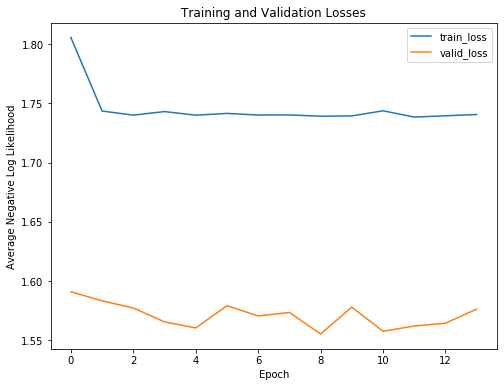

In [50]:
plt.figure(figsize=(8, 6))
for c in ['train_loss', 'valid_loss']:
    plt.plot(
        history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Negative Log Likelihood')
plt.title('Training and Validation Losses')

Text(0.5, 1.0, 'Training and Validation Accuracy')

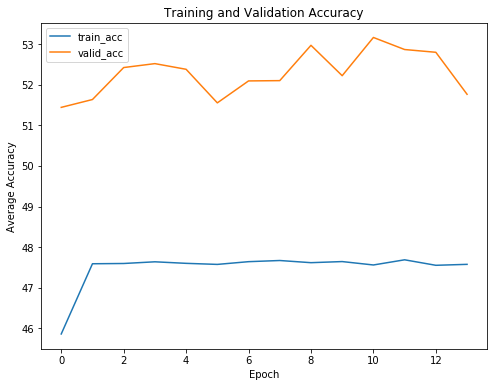

In [51]:
plt.figure(figsize=(8, 6))
for c in ['train_acc', 'valid_acc']:
    plt.plot(
        100 * history[c], label=c)
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
plt.title('Training and Validation Accuracy')

In [69]:
def process_image(image_path):
    """Process an image path into a PyTorch tensor"""

    image = Image.open(image_path)
    
    # rescale such that smaller size equals 299
    width, height = image.size
    ratio = float(width) / height
    if ratio < 1:
        width = INCEPTION_V3_IMG_SIZE
        height = INCEPTION_V3_IMG_SIZE / ratio
    else:
        height = INCEPTION_V3_IMG_SIZE
        width = height * ratio
    img = image.resize((int(width), int(height)))

    # Center crop
    left = (width - INCEPTION_V3_IMG_SIZE) / 2
    top = (height - INCEPTION_V3_IMG_SIZE) / 2
    right = left + INCEPTION_V3_IMG_SIZE
    bottom = top + INCEPTION_V3_IMG_SIZE
    img = img.crop((left, top, right, bottom))

    # Convert to numpy, transpose color dimension and normalize
    img = np.array(img).transpose((2, 0, 1)) / 256

    # Standardization
    means = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    stds = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))

    img = img - means
    img = img / stds

    img_tensor = torch.Tensor(img)

    return img_tensor

In [70]:
def imshow_tensor(image, ax=None, title=None):
    """Imshow for Tensor."""

    if ax is None:
        fig, ax = plt.subplots()

    # Set the color channel as the third dimension
    image = image.numpy().transpose((1, 2, 0))

    # Reverse the preprocessing steps
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean

    # Clip the image pixel values
    image = np.clip(image, 0, 1)

    ax.imshow(image)
    plt.axis('off')

    return ax, image

In [73]:
# print(os.listdir(testdir + 'Blouse/'))
x = process_image(testdir + 'Blouse/Embroidered_Mesh_Gauze_Blouse_img_00000036.jpg') # CHANGE FILE PATH !!!
x.shape

torch.Size([3, 299, 300])

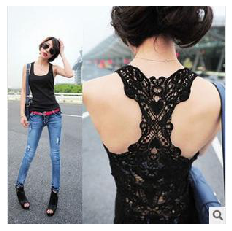

In [74]:
ax, image = imshow_tensor(x)

In [78]:
def predict(image_path, model, topk=5):
    """Make a prediction for an image using a trained model

    Params
    --------
        image_path (str): filename of the image
        model (PyTorch model): trained model for inference
        topk (int): number of top predictions to return

    Returns

    """
    real_class = image_path.split('/')[-2]

    # Convert to pytorch tensor
    img_tensor = process_image(image_path)

    # Resize
    if train_on_gpu:
        img_tensor = img_tensor.view(1, 3, INCEPTION_V3_IMG_SIZE, INCEPTION_V3_IMG_SIZE).cuda()
    else:
        img_tensor = img_tensor.view(1, 3, INCEPTION_V3_IMG_SIZE, INCEPTION_V3_IMG_SIZE)

    # Set to evaluation
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(img_tensor)
        ps = torch.exp(out)

        # Find the topk predictions
        topk, topclass = ps.topk(topk, dim=1)

        # Extract the actual classes and probabilities
        top_classes = [
            model.idx_to_class[class_] for class_ in topclass.cpu().numpy()[0]
        ]
        top_p = topk.cpu().numpy()[0]

        return img_tensor.cpu().squeeze(), top_p, top_classes, real_class

In [79]:
def display_prediction(image_path, model, topk):
    """Display image and preditions from model"""

    # Get predictions
    img, ps, classes, y_obs = predict(image_path, model, topk)
    # Convert results to dataframe for plotting
    result = pd.DataFrame({'p': ps}, index=classes)

    # Show the image
    plt.figure(figsize=(16, 5))
    ax = plt.subplot(1, 2, 1)
    ax, img = imshow_tensor(img, ax=ax)

    # Set title to be the actual class
    ax.set_title(y_obs, size=20)

    ax = plt.subplot(1, 2, 2)
    # Plot a bar plot of predictions
    result.sort_values('p')['p'].plot.barh(color='blue', edgecolor='k', ax=ax)
    plt.xlabel('Predicted Probability')
    plt.tight_layout()

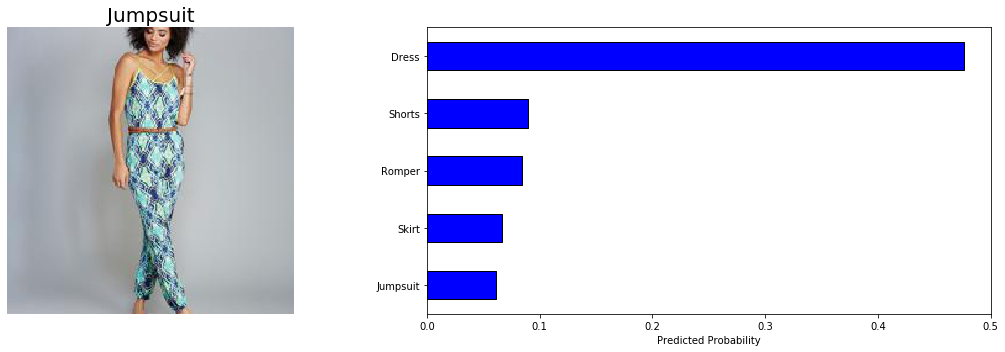

In [80]:
display_prediction('dataset/ds1/valid/Jumpsuit/Abstract_Print_Jumpsuit_img_00000002.jpg', model, topk=5)

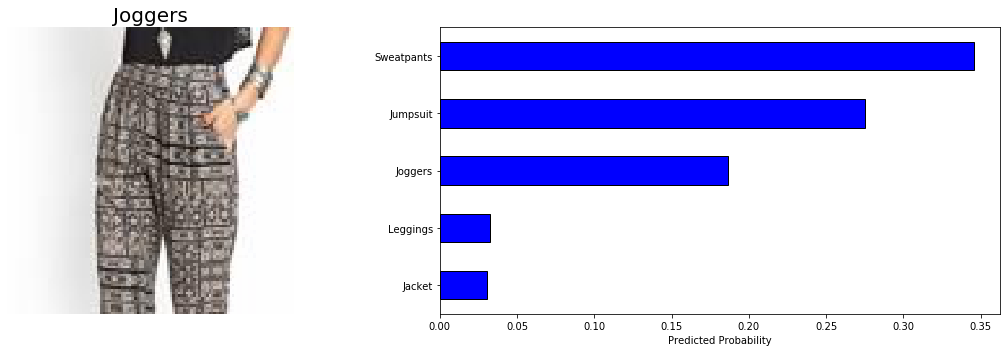

In [95]:
display_prediction('dataset/ds1/valid/Joggers/Abstract_Woven_Joggers_img_00000023.jpg', model, topk=5)

In [81]:
def accuracy(output, target, topk=(1, )):
    """Compute the topk accuracy(s)"""
    if train_on_gpu:
        output = output.to('cuda')
        target = target.to('cuda')

    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        # Find the predicted classes and transpose
        _, pred = output.topk(k=maxk, dim=1, largest=True, sorted=True)
        pred = pred.t()

        # Determine predictions equal to the targets
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []

        # For each k, find the percentage of correct
        for k in topk:
            correct_k = correct[:k].view(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size).item())
        return res

In [82]:
testiter = iter(dataloaders['test'])
# Get a batch of testing images and labels
features, targets = next(testiter)

if train_on_gpu:
    accuracy(model(features.to('cuda')), targets, topk=(1, 5))
else:
    accuracy(model(features), targets, topk=(1, 5))

In [85]:
def evaluate(model, test_loader, criterion, topk=(1, 5)):
    """Measure the performance of a trained PyTorch model

    Params
    --------
        model (PyTorch model): trained cnn for inference
        test_loader (PyTorch DataLoader): test dataloader
        topk (tuple of ints): accuracy to measure

    Returns
    --------
        results (DataFrame): results for each category

    """

    classes = []
    losses = []
    # Hold accuracy results
    acc_results = np.zeros((len(test_loader.dataset), len(topk)))
    i = 0

    model.eval()
    with torch.no_grad():

        # Testing loop
        for data, targets in test_loader:

            # Tensors to gpu
            if train_on_gpu:
                data, targets = data.to('cuda'), targets.to('cuda')

            # Raw model output
            out = model(data)
            # Iterate through each example
            for pred, true in zip(out, targets):
                # Find topk accuracy
                acc_results[i, :] = accuracy(
                    pred.unsqueeze(0), true.unsqueeze(0), topk)
                classes.append(model.idx_to_class[true.item()])
                # Calculate the loss
                loss = criterion(pred.view(1, len(pred)), true.view(1))
                losses.append(loss.item())
                i += 1

    # Send results to a dataframe and calculate average across classes
    results = pd.DataFrame(acc_results, columns=[f'top{i}' for i in topk])
    results['class'] = classes
    results['loss'] = losses
    results = results.groupby(classes).mean()

    return results.reset_index().rename(columns={'index': 'class'})

In [86]:
criterion = nn.NLLLoss()
# Evaluate the model on all the training data
results = evaluate(model, dataloaders['test'], criterion)
results.head()

,class,top1,top5,loss
0,Blazer,48.715415,82.411067,1.676026
1,Blouse,42.232278,95.625943,1.685299
2,Cardigan,27.545910,77.128548,2.184548
3,Coat,22.027972,58.741259,2.894674
4,Dress,84.376925,98.090741,0.781572


In [92]:
cat_df

,category,category_size
36,41,72158
5,18,36887
0,3,24557
21,32,19666
6,17,15429
20,33,14773
11,6,13311
8,16,13123
12,11,10467
7,19,10078


In [94]:
results

,class,top1,top5,loss,category_size_x,category_size_y,category_size_x,category_size_y,category_size


(-5, 105)

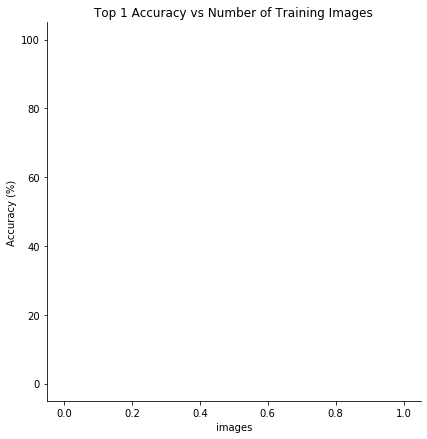

In [93]:
# We'd expect the model to do better on those classes for which it had the most training images. We can see if that is the case.
results = results.merge(cat_df, left_on='class', right_on='category').\
    drop(columns=['category'])

# Plot using seaborn
sns.lmplot(
    y='top1', x='category_size', data=results, height=6)
plt.xlabel('images')
plt.ylabel('Accuracy (%)')
plt.title('Top 1 Accuracy vs Number of Training Images')
plt.ylim(-5, 105)